In [1]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('acc') >= 0.96):   
            print("Reached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [3]:
EPOCHS = 50
INIT_LR = 3e-3
BS =32
default_image_size = tuple((150, 150))
image_size = 0
width=150
height=150
depth=3
train_dir=r"D:\DP\bloodcell\images\TRAIN"
#valid_dir=r"C:\Users\Glau\Desktop\DP\Pediastrum_cnn\Test"
train_folder=listdir(train_dir)
#valid_folder=listdir(valid_dir)

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
callbacks = MyCustomCallback()

In [6]:
train_image_list, train_image_label= [], []
for disease_folder in train_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{train_dir}/{disease_folder}")
    #print(disease_img_folder)
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]:    
        image_directory = f"{train_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpeg") == True or image_directory.endswith(".jpg") == True or  image_directory.endswith(".png") == True:
            train_image_list.append(convert_image_to_array(image_directory))
            train_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing EOSINOPHIL ...
processing LYMPHOCYTE ...
processing MONOCYTE ...
processing NEUTROPHIL ...
[INFO] Image loading completed


In [7]:
print(len(train_image_label))

12436


In [8]:
label_binarizer = LabelBinarizer()
bin_train_image_labels = label_binarizer.fit_transform(train_image_label)
#bin_valid_image_labels = label_binarizer.fit_transform(valid_image_label)
pickle.dump(label_binarizer,open('Label_Instance_bloodcell1.pk', 'wb'))
n_classes = len(label_binarizer.classes_)

In [9]:
print(len(bin_train_image_labels))

12436


In [10]:
np_train_image_list = np.array(train_image_list, dtype=np.float32) / 255.0

In [11]:
print(len(np_train_image_list))

12436


In [17]:
# coding: utf8
from tensorflow.keras import layers
from tensorflow.keras import models


#
# image dimensions
#

img_height = 150
img_width = 150
img_channels = 3

#
# network params
#

cardinality = 32


def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:

        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 64, 128, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 128, 256, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv5
    for i in range(3):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512,1024, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(4,activation='softmax')(x)

    return x


image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_549 (Conv2D)             (None, 75, 75, 64)   4864        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 75, 75, 64)   256         conv2d_549[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_49 (LeakyReLU)      (None, 75, 75, 64)   0           batch_normalization_53[0][0]     
____________________________________________________________________________________________

lambda_893 (Lambda)             (None, 10, 10, 8)    0           leaky_re_lu_83[0][0]             
__________________________________________________________________________________________________
lambda_894 (Lambda)             (None, 10, 10, 8)    0           leaky_re_lu_83[0][0]             
__________________________________________________________________________________________________
lambda_895 (Lambda)             (None, 10, 10, 8)    0           leaky_re_lu_83[0][0]             
__________________________________________________________________________________________________
conv2d_928 (Conv2D)             (None, 10, 10, 8)    584         lambda_864[0][0]                 
__________________________________________________________________________________________________
conv2d_929 (Conv2D)             (None, 10, 10, 8)    584         lambda_865[0][0]                 
__________________________________________________________________________________________________
conv2d_930

In [18]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [19]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

print("[INFO] training network...")

[INFO] training network...


In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,classification_report 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer

In [21]:
conf_matrix_list_of_arrays = []
#loss_per_fold = []
seed = 13   # for reproducibility you can change it. 
np.random.seed(seed)
kfold = KFold(5, True, seed)
for train_idx, val_idx in kfold.split(np_train_image_list, y=bin_train_image_labels):
    #print('train: %s, val: %s' % (train_idx, val_idx))
    x_train, x_val = np_train_image_list[train_idx], np_train_image_list[val_idx]
    y_train, y_val = bin_train_image_labels[train_idx], bin_train_image_labels[val_idx]
    history=model.fit(x_train, y_train,
                  validation_data=(x_val, y_val),
                  batch_size=BS,
                  epochs=EPOCHS, verbose=1        
                  )
    ycalculated = model.predict(x_val)
    yhat_classes =np.argmax(ycalculated,axis=1)
    rounded_labels=np.argmax(y_val,axis=1)                           
    conf_matrix = confusion_matrix(rounded_labels,yhat_classes)
    conf_matrix_list_of_arrays .append(conf_matrix)


Train on 9948 samples, validate on 2488 samples
Epoch 1/50
9948/9948 [==============================] - 128s 13ms/sample - loss: 0.9301 - accuracy: 0.6279 - val_loss: 2.4854 - val_accuracy: 0.3312
Epoch 2/50
9948/9948 [==============================] - 80s 8ms/sample - loss: 0.4353 - accuracy: 0.8236 - val_loss: 40.8752 - val_accuracy: 0.2633
Epoch 3/50
9948/9948 [==============================] - 81s 8ms/sample - loss: 0.3187 - accuracy: 0.8741 - val_loss: 20.7402 - val_accuracy: 0.2934
Epoch 4/50
9948/9948 [==============================] - 82s 8ms/sample - loss: 0.3230 - accuracy: 0.8762 - val_loss: 14.4364 - val_accuracy: 0.4682
Epoch 5/50
9948/9948 [==============================] - 80s 8ms/sample - loss: 0.2017 - accuracy: 0.9207 - val_loss: 4.7543 - val_accuracy: 0.4108
Epoch 6/50
9948/9948 [==============================] - 79s 8ms/sample - loss: 0.1962 - accuracy: 0.9244 - val_loss: 7.1258 - val_accuracy: 0.4739
Epoch 7/50
9948/9948 [==============================] - 80s 8ms/s

Epoch 6/50
9949/9949 [==============================] - 79s 8ms/sample - loss: 0.0243 - accuracy: 0.9925 - val_loss: 0.0542 - val_accuracy: 0.9815
Epoch 7/50
9949/9949 [==============================] - 79s 8ms/sample - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.0427 - val_accuracy: 0.9795
Epoch 8/50
9949/9949 [==============================] - 79s 8ms/sample - loss: 0.0170 - accuracy: 0.9946 - val_loss: 0.1364 - val_accuracy: 0.9618
Epoch 9/50
9949/9949 [==============================] - 79s 8ms/sample - loss: 0.0042 - accuracy: 0.9987 - val_loss: 0.0735 - val_accuracy: 0.9787
Epoch 10/50
9949/9949 [==============================] - 79s 8ms/sample - loss: 0.0041 - accuracy: 0.9983 - val_loss: 0.0496 - val_accuracy: 0.9843
Epoch 11/50
9949/9949 [==============================] - 79s 8ms/sample - loss: 0.0240 - accuracy: 0.9922 - val_loss: 3.9439 - val_accuracy: 0.6655
Epoch 12/50
9949/9949 [==============================] - 80s 8ms/sample - loss: 0.0106 - accuracy: 0.9966 - val_loss

Epoch 11/50
9949/9949 [==============================] - 80s 8ms/sample - loss: 0.0014 - accuracy: 0.9996 - val_loss: 7.3585e-04 - val_accuracy: 1.0000
Epoch 12/50
9949/9949 [==============================] - 80s 8ms/sample - loss: 0.0174 - accuracy: 0.9962 - val_loss: 0.0083 - val_accuracy: 0.9968
Epoch 13/50
9949/9949 [==============================] - 81s 8ms/sample - loss: 0.0013 - accuracy: 0.9996 - val_loss: 2.1480e-04 - val_accuracy: 1.0000
Epoch 14/50
9949/9949 [==============================] - 81s 8ms/sample - loss: 4.5794e-04 - accuracy: 1.0000 - val_loss: 0.0152 - val_accuracy: 0.9952
Epoch 15/50
9949/9949 [==============================] - 79s 8ms/sample - loss: 3.1985e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9996
Epoch 16/50
9949/9949 [==============================] - 80s 8ms/sample - loss: 6.9974e-04 - accuracy: 0.9997 - val_loss: 0.0464 - val_accuracy: 0.9839
Epoch 17/50
9949/9949 [==============================] - 80s 8ms/sample - loss: 0.0016 - acc

Epoch 15/50
9949/9949 [==============================] - 80s 8ms/sample - loss: 2.4452e-04 - accuracy: 1.0000 - val_loss: 1.7968e-04 - val_accuracy: 1.0000
Epoch 16/50
9949/9949 [==============================] - 81s 8ms/sample - loss: 2.3181e-04 - accuracy: 1.0000 - val_loss: 0.0505 - val_accuracy: 0.9851
Epoch 17/50
9949/9949 [==============================] - 82s 8ms/sample - loss: 7.3003e-04 - accuracy: 0.9996 - val_loss: 8.4967e-04 - val_accuracy: 0.9996
Epoch 18/50
9949/9949 [==============================] - 80s 8ms/sample - loss: 8.0379e-04 - accuracy: 0.9998 - val_loss: 1.2744e-04 - val_accuracy: 1.0000
Epoch 19/50
9949/9949 [==============================] - 81s 8ms/sample - loss: 0.0022 - accuracy: 0.9993 - val_loss: 9.4511e-04 - val_accuracy: 0.9996
Epoch 20/50
9949/9949 [==============================] - 80s 8ms/sample - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.0124 - val_accuracy: 0.9968
Epoch 21/50
9949/9949 [==============================] - 80s 8ms/sample - loss: 

KeyboardInterrupt: 

In [ ]:
for i in range(0,5):
    cm=conf_matrix_list_of_arrays[i]
    print(cm)

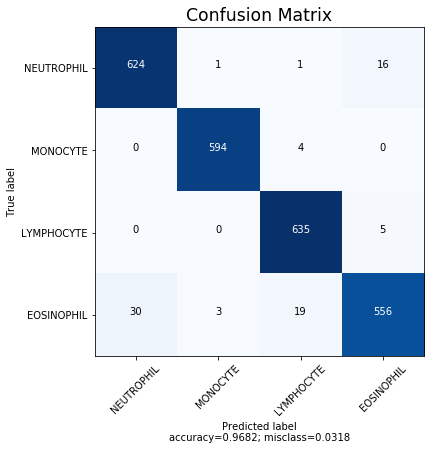

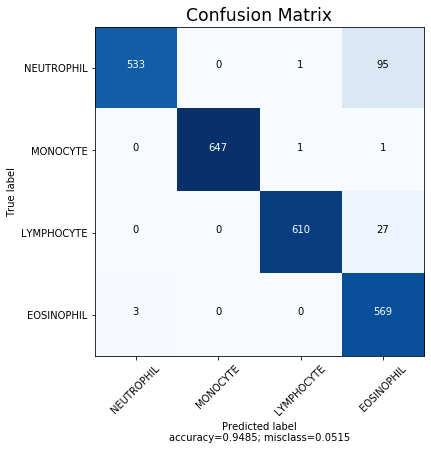

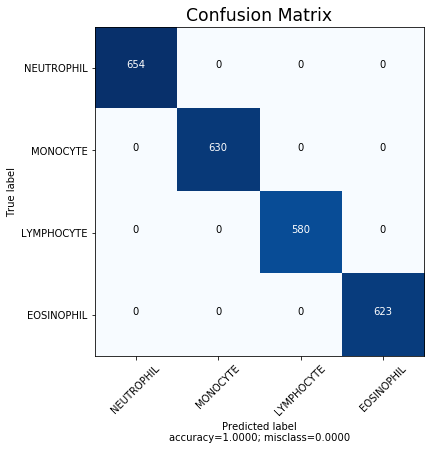

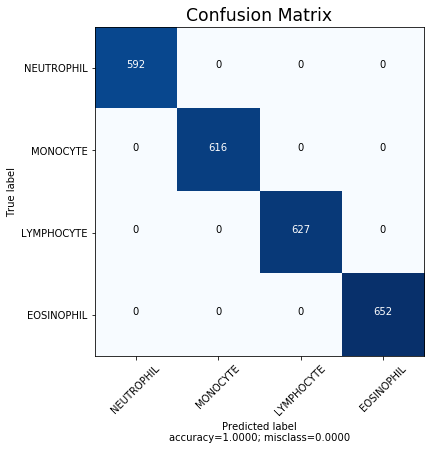

In [22]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
for i in range(0,4):
    plot_confusion_matrix(conf_matrix_list_of_arrays[i], 
                      normalize = False,
                      target_names = ['NEUTROPHIL','MONOCYTE','LYMPHOCYTE','EOSINOPHIL'],
                      title        = "Confusion Matrix")

In [ ]:
from sklearn.metrics import accuracy_score,classification_report 
target_names = ['NEUTROPHIL','MONOCYTE','LYMPHOCYTE','EOSINOPHIL']
print(classification_report(rounded_labels, yhat_classes, target_names=target_names))


In [ ]:
cm=conf_matrix_list_of_arrays[4]
print(cm)

In [ ]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
#cm = confusion_matrix(testY, np.argmax(predY, axis = -1))
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision=  cm[0, 0] /(cm[0,1]+cm[0,0])
recall=cm[0,0] /(cm[0,0]+cm[1,0])
f1_score=2*((precision*recall)/(precision+recall))
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)

print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))
#print("precision: {:.4f}".format(precision))
#print("recall: {:.4f}".format(recall))
#print("f1_score: {:.4f}".format(f1_score))

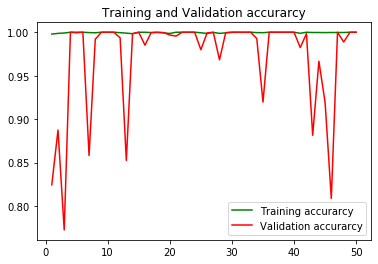

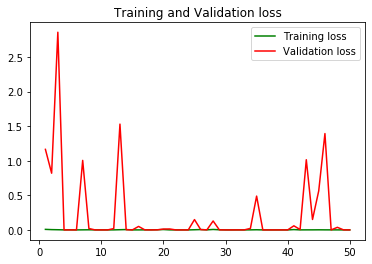

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
class_to_label_map={ 0 : 'NEUTROPHIL', 1 : 'MONOCYTE',2:'LYMPHOCYTE',3:'EOSINOPHIL'}

In [ ]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

n_classes =4

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
lb = LabelBinarizer()
lb.fit(rounded_labels)
y_test= lb.transform(rounded_labels)
snn_pred = lb.transform(yhat_classes)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], snn_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), snn_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes-97), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw,color='white')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Cell')
plt.legend(loc="lower right")
plt.show()

